# Setup

### Load contents of setup.py

In [2]:
# %load setup.py
import cv2
import h5py  # hdf5 reader/writer
import hyperspy.api as hs  # hyperspy
import ImageProcessingMethods as ipm
import math
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import skimage

from scipy import ndimage as ndi
from scipy import signal
from scipy.ndimage.filters import gaussian_filter

# Load signal data from files

fin_1 = h5py.File("data/89109_16_Fe_mantis_norm.hdf5")
data_1 = fin_1["/exchange/data"]
signal_1 = hs.signals.Signal2D(data_1)
signal_1 = signal_1.transpose(signal_axes=(0,2))

fin_2 = h5py.File("data/mantis_55510_55660.hdf5")
data_2 = fin_2["/exchange/data"]
signal_2 = hs.signals.Signal2D(data_2)
signal_2 = signal_2.transpose(signal_axes=(0,2))

fin_3 = h5py.File("data/mantis_raw_55499_55509.hdf5")
data_3 = fin_3["/exchange/data"]
signal_3 = hs.signals.Signal2D(data_3)
signal_3 = signal_3.transpose(signal_axes=(0,2))

signal_4 = hs.load("data/0005-RotSTEM90 ADF1.dm3")
signal_5 = hs.load("data/20_Aligned 20-Stack-5MxHAADF STACK(20).dm3")

# Generate a very simple synthetic signal for demonstration purposes

height = 38
width = 46

vfield_1 = np.array([np.ones((height, width)) * -2, np.ones((height, width)) * +1])
vfield_2 = np.array([np.ones((height, width)) * -2.7, np.ones((height, width)) * +1.2])

arr_A = ipm.make_capital_A((height, width))
signal_A = hs.signals.Signal2D(np.array([arr_A, ipm.apply_displacement_field_sitk(vfield_1, arr_A), ipm.apply_displacement_field_sitk(vfield_2, arr_A)]))

arr_i = np.arange(height).reshape(height, 1)
arr_j = np.arange(width).reshape(1, width)
# i_plus, i_minus: vertical coordinates of +ve and -ve 'charges'
i_plus = height * 0.75
i_minus = height * 0.25
# j_plus, j_minus: horizontal coordinates of +ve and -ve 'charges'
j_plus = width * 0.25
j_minus = width * 0.75
# dsquared_plus[i][j] = distance squared between +ve 'charge' and pixel i,j
# dsquared_minus[i][j] = distance squared between -ve 'charge' and pixel i,j
dsquared_plus = (arr_i - i_plus)**2 + (arr_j - j_plus)**2
dsquared_minus = (arr_i - i_minus)**2 + (arr_j - j_minus)**2
scale = 2
power = 2

# vfield_3 represents a shift similar to the force experienced by a small test charge under the influence of two fixed point charges: one positive, one negative. Unlike vfield_1 and vfield_2, it is non-uniform.
# vfield_3[i][j] = scale * sum[r_hat * 'charge' * (1/distance from 'charge')^power]
# r_hat = (i - i_plus)/(dsquared^0.5)
# therefore vfield_3[i][j] = scale * sum[(i - i_plus) * 'charge' * (1/distance from 'charge')^(power+1)]
factor_plus = scale * (dsquared_plus**(-0.5*(1+power)))
factor_minus = scale * (dsquared_minus**(-0.5*(1+power)))
vfield_3_i = (arr_i - i_plus) * factor_plus + (i_minus - arr_i) * factor_minus
vfield_3_j = (arr_j - j_plus) * factor_plus + (j_minus - arr_j) * factor_minus
vfield_3 = np.array([vfield_3_i, vfield_3_j])

### Display the unmodified datasets
Use `%matplotlib qt` to set up IPython for interactive plotting with matplotlib.

In [5]:
%matplotlib qt
signal_1.plot()

In [10]:
%matplotlib qt
signal_2.plot()

In [10]:
%matplotlib qt
signal_3.plot()

In [4]:
%matplotlib qt
signal_4.plot()

In [5]:
%matplotlib qt
signal_5.plot()

In [10]:
%matplotlib qt
signal_A.plot()

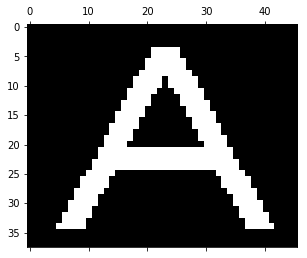

In [2]:
plt.matshow(arr_A)

# Method demonstrations

## Comparing each pixel with the image as a whole

#### `ipm.get_signal_average_difference( signal_in: hs.signals.Signal2D )`

Average intensity difference across whole image from current pixel.

A'(i, j) = mean value of |A - A(i, j)|

In [7]:
avg_diff_1 = ipm.get_signal_average_difference(signal_1)

In [5]:
%matplotlib qt
hs.plot.plot_signals([signal_1, avg_diff_1])

#### `ipm.get_signal_average_rank_difference( signal_in: hs.signals.Signal2D, weighted=False )`

Average intensity rank difference across whole image from current pixel.

A'(i, j) = mean value of |R - R(i, j)|, where A(i, j) is the R(i, j)<sup>th</sup>-brightest pixel

If `weighted` is True, the differences are each multiplied by the mean value of the absolute difference between the current image and the intensity of the current pixel.

In [6]:
avg_rank_diff_1 = ipm.get_signal_average_rank_difference(signal_1)
avg_rank_diff_1_weighted = ipm.get_signal_average_rank_difference(signal_1, weighted=True)

In [7]:
%matplotlib qt
hs.plot.plot_signals([signal_1, avg_diff_1, avg_rank_diff_1, avg_rank_diff_1_weighted])

## Exploring a signal's temporal characteristics

#### `ipm.get_deltas( signal_in: hs.signals.Signal2D, absolute=False, normalised=True )`

Difference between next and current intensity of each pixel.

Returns a signal of type `hs.signals.Signal2D`

In [6]:
deltas_1 = ipm.get_deltas(signal_1)
# deltas_1.data[t] = signal_1.data[t+1] - signal_1.data[t]

# Append an all-zero image to deltas_1 so that deltas_1 has the same number of images as signal_1
deltas_1 = hs.signals.Signal2D(np.append(deltas_1.data, [np.zeros_like(deltas_1.data[0])], axis=0))

# Display signal_1 and deltas_1
hs.plot.plot_signals([signal_1, deltas_1])

#### `ipm.split_by_mutual_information( signal_in: hs.signals.Signal2D, threshold=0.3 )`

Split a signal into a list of numpy arrays of images. Each numpy array in the list contains a subsection of the original signal. For each image in a subsection, the mutual information between that image and the first image in the subsection must be at least some value given by the `threshold` parameter.

In [4]:
list_1 = ipm.split_by_mutual_information(signal_1)
list_2 = ipm.split_by_mutual_information(signal_2)
list_3 = ipm.split_by_mutual_information(signal_3)

#### Print the number of subsections in each list

In [5]:
[len(list_1), len(list_2), len(list_3)]

[24, 10, 1]

#### Print the number of images in each subsection of each list

In [6]:
lengths = [[],[],[]]
for i in range(len(list_1)):
    lengths[0].append(list_1[i].shape[0])
for i in range(len(list_2)):
    lengths[1].append(list_2[i].shape[0])
for i in range(len(list_3)):
    lengths[2].append(list_3[i].shape[0])
lengths

[[11, 38, 25, 26, 1, 3, 2, 1, 3, 2, 1, 4, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [61, 78, 4, 1, 1, 1, 1, 1, 1, 1],
 [1]]

#### Display the images in the first subsection of `list_1`

In [7]:
%matplotlib qt
hs.signals.Signal2D(list_1[0]).plot()

#### Apply nonrigid registration to this subsection. Display both the original and registered signal.

In [8]:
out_stack = ipm.nonrigid(list_1[0], default_pixel_value = list_1[0].mean())
%matplotlib qt
hs.plot.plot_signals([hs.signals.Signal2D(list_1[0]), hs.signals.Signal2D(out_stack)])

#### `ipm.highest_mutual_information_index(signal_in: hs.signals.Signal2D, exponent=1)`

Iterates over an image stack. For each image, the sum of the mutual information between that image and each other image (raised to the power `exponent`) is calculated. The index of the image for which this value is greatest is returned.

For `exponent` values less than 1, low mutual information pairs are more heavily penalised: the index returned will correspond to an image that is moderately representative of the whole stack.
    
For `exponent` values greater than 1, high mutual information pairs are more strongly rewarded: the index returned will correspond to an image that is highly representative of some subset of the stack.

In [12]:
max_mi_1 = ipm.highest_mutual_information_index(signal_1)
max_mi_2 = ipm.highest_mutual_information_index(signal_2)
max_mi_3 = ipm.highest_mutual_information_index(signal_3)
max_mi_4 = ipm.highest_mutual_information_index(signal_4)
max_mi_5 = ipm.highest_mutual_information_index(signal_5)
max_mi_A = ipm.highest_mutual_information_index(signal_A)

#### Print the image indices returned above

In [19]:
[max_mi_1, max_mi_2, max_mi_3, max_mi_4, max_mi_5, max_mi_A]

[33, 66, 7, 18, 8, 1]

#### Display the image in `signal_1` corresponding to the index `max_mi_1`. This may be considered as the element of `signal_1` that best represents the whole image stack.

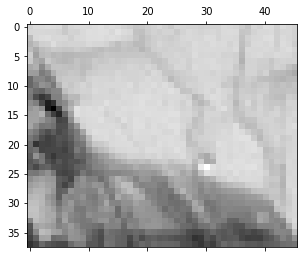

In [13]:
plt.matshow(signal_1.data[max_mi_1])

#### Display the "most representative" image in `signal_2`

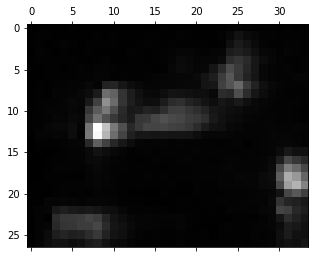

In [18]:
plt.matshow(signal_2.data[max_mi_2])

#### Display the "most representative" image in `signal_3`

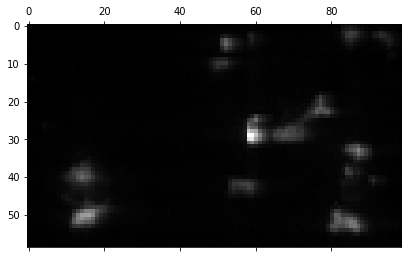

In [17]:
plt.matshow(signal_3.data[max_mi_3])

#### Display the "most representative" image in `signal_4`

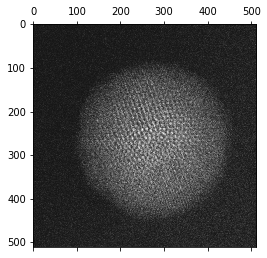

In [16]:
plt.matshow(signal_4.data[max_mi_4])

#### Display the "most representative" image in `signal_5`

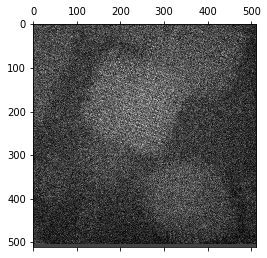

In [15]:
plt.matshow(signal_5.data[max_mi_5])

#### Display the "most representative" image in `signal_A`

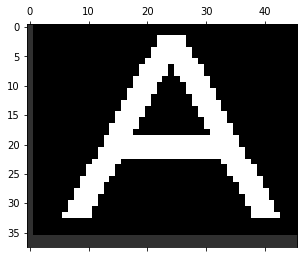

In [14]:
plt.matshow(signal_A.data[max_mi_A])

## Exploring a signal's spatial characteristics

#### `ipm.get_neighbour_similarity( arr_in: np.array, exponent=2 )`

Similarity to neighbouring pixels relative to whole image.
    
The purpose of this method is to obtain a measure of confidence in the intensity value of each pixel. High confidence values are given to pixels that are similar to their neighbours and dissimilar from the average pixel.

The optional `exponent` parameter controls the strength with which distance between pixels is penalised. If `exponent` is large (say, greater than 2), only pixels very close to the pixel under consideration may be considered 'neighbours'.

Ultimately, this or a similar method may be used in conjunction with an optical flow algorithm to determine the strength of the smoothness constraint at each point.

The current implementation of this method is quite crude, but nonetheless produces qualitatively sensible results.

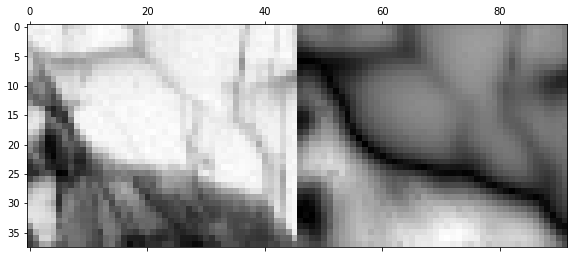

In [6]:
# Run `get_neighbour_similarity` on one of the clearer images in signal_1
ns_1_94 = ipm.get_neighbour_similarity(signal_1.data[94])

# Normalise both arrays (otherwise the original appears very light and ns_1_94 appears very dark)
range_pre = signal_1.data[94].max() - signal_1.data[94].min()
signal_1_94_normalised = (signal_1.data[94] - signal_1.data[94].min()) / range_pre
range_post = ns_1_94.max() - ns_1_94.min()
ns_1_94_normalised = (ns_1_94 - ns_1_94.min()) / range_post

# Display side by side
plt.matshow(np.hstack((signal_1_94_normalised, ns_1_94_normalised)))

#### `ipm.get_signal_neighbour_similarity( signal_in: hs.signals.Signal2D, exponent=2 )`

Run `get_neighbour_similarity` on a whole image stack.

In [10]:
ns_2 = ipm.get_signal_neighbour_similarity(signal_2)
%matplotlib qt
hs.plot.plot_signals([signal_2, ns_2])

## Applying a displacement field

#### `ipm.apply_displacement_field( displacements: np.array, arr_2d_in: np.array, debug=False )`

Apply a displacement field to an image.

`displacements` (numpy array of shape (2, height, width)) is a pair of displacement fields: the first is vertical and the second is horizontal.

`arr_2d_in` (numpy array of shape (height, width)) is the image to which the displacement field will be applied.

A list of length 2 is returned. The first element is a displaced image (numpy array of shape (height, width)). The second element is a "sum of weights" matrix (used for debugging).

In [5]:
[shifted_A1, sow_A1] = ipm.apply_displacement_field(vfield_1, arr_A)
[shifted_A2, sow_A2] = ipm.apply_displacement_field(vfield_2, arr_A)
[shifted_A3, sow_A3] = ipm.apply_displacement_field(vfield_3, arr_A)

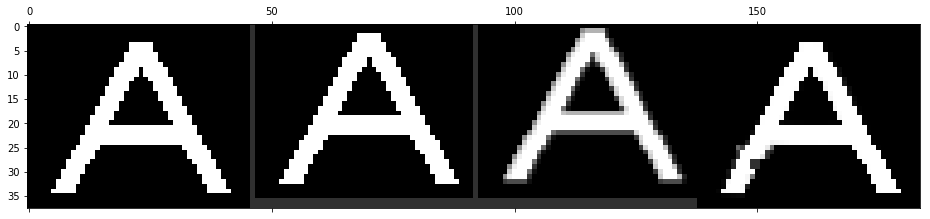

In [9]:
plt.matshow(np.hstack((arr_A, shifted_A1, shifted_A2, shifted_A3)))

#### `ipm.apply_displacement_field_sitk( displacements: np.array, arr_2d_in: np.array, rearrange=True )`

Apply a displacement field using SimpleITK.

A displaced image (numpy array of shape (height, width)) is returned.

In [7]:
shifted_A1_sitk = ipm.apply_displacement_field_sitk(vfield_1, arr_A)
shifted_A2_sitk = ipm.apply_displacement_field_sitk(vfield_2, arr_A)
shifted_A3_sitk = ipm.apply_displacement_field_sitk(vfield_3, arr_A)

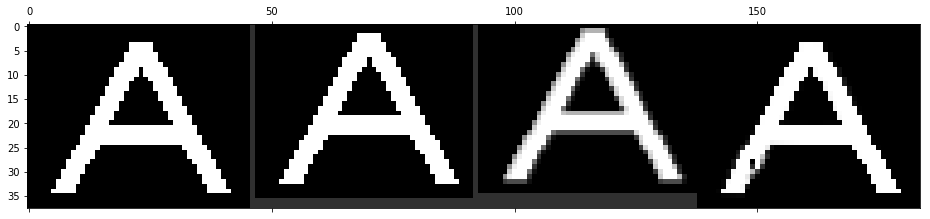

In [10]:
plt.matshow(np.hstack((arr_A, shifted_A1_sitk, shifted_A2_sitk, shifted_A3_sitk)))

Note that there are differences between `shifted_A2` and `shifted_A2_sitk`, and between `shifted_A3` and `shifted_A3_sitk`. The SITK method for applying a displacement field will henceforth be used instead of `ipm.apply_displacement_field`.

## Rigid registration

#### `hs.signals.Signal2D.estimate_shift2D( reference='current', correlation_threshold=None, chunk_size=30, roi=None, normalize_corr=False, sobel=True, medfilter=True, hanning=True, plot=False, dtype='float', show_progressbar=None, sub_pixel_factor=1 )`

#### Estimate shifts relative to the first image in the stack

In [4]:
shifts_1 = signal_1.estimate_shift2D(reference='current', sobel=True, medfilter=True, hanning=True, sub_pixel_factor=50)
shifts_2 = signal_2.estimate_shift2D(reference='current', sobel=True, medfilter=True, hanning=True, sub_pixel_factor=50)
shifts_3 = signal_3.estimate_shift2D(reference='current', sobel=True, medfilter=True, hanning=True, sub_pixel_factor=50)
shifts_4 = signal_4.estimate_shift2D(reference='current', sobel=True, medfilter=True, hanning=True, sub_pixel_factor=50)
shifts_5 = signal_5.estimate_shift2D(reference='current', sobel=True, medfilter=True, hanning=True, sub_pixel_factor=50)
shifts_A = signal_A.estimate_shift2D(reference='current', sobel=True, medfilter=True, hanning=True, sub_pixel_factor=50)

/dls_sw/apps/python/anaconda/1.7.0/64/envs/python3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


#### Correct for estimated shifts

In [5]:
signal_1_shifted = ipm.correct_shifts_vh(signal_1, shifts_1)
signal_2_shifted = ipm.correct_shifts_vh(signal_2, shifts_2)
signal_3_shifted = ipm.correct_shifts_vh(signal_3, shifts_3)
signal_4_shifted = ipm.correct_shifts_vh(signal_4, shifts_4)
signal_5_shifted = ipm.correct_shifts_vh(signal_5, shifts_5)
signal_A_shifted = ipm.correct_shifts_vh(signal_A, shifts_A)

#### Display original and shifted signals

In [6]:
%matplotlib qt
hs.plot.plot_signals([signal_1, signal_1_shifted])

In [9]:
%matplotlib qt
hs.plot.plot_signals([signal_2, signal_2_shifted])

In [ ]:
%matplotlib qt
hs.plot.plot_signals([signal_3, signal_3_shifted])

In [8]:
%matplotlib qt
hs.plot.plot_signals([signal_4, signal_4_shifted])

In [ ]:
%matplotlib qt
hs.plot.plot_signals([signal_5, signal_5_shifted])

In [7]:
%matplotlib qt
hs.plot.plot_signals([signal_A, signal_A_shifted])

#### `ipm.estimate_shift_relative_to_most_representative_image(signal_in: hs.signals.Signal2D, exponent=1, sub_pixel_factor=50)`

#### Estimate shifts

The "most representative" image is determined using `ipm.highest_mutual_information_index`.

In [8]:
shifts_1_v2 = ipm.estimate_shift_relative_to_most_representative_image(signal_1)
shifts_2_v2 = ipm.estimate_shift_relative_to_most_representative_image(signal_2)
shifts_3_v2 = ipm.estimate_shift_relative_to_most_representative_image(signal_3)
shifts_4_v2 = ipm.estimate_shift_relative_to_most_representative_image(signal_4)
shifts_5_v2 = ipm.estimate_shift_relative_to_most_representative_image(signal_5)
shifts_A_v2 = ipm.estimate_shift_relative_to_most_representative_image(signal_A)

#### Correct for estimated shifts

In [9]:
signal_1_shifted_v2 = ipm.correct_shifts_vh(signal_1, shifts_1_v2)
signal_2_shifted_v2 = ipm.correct_shifts_vh(signal_2, shifts_2_v2)
signal_3_shifted_v2 = ipm.correct_shifts_vh(signal_3, shifts_3_v2)
signal_4_shifted_v2 = ipm.correct_shifts_vh(signal_4, shifts_4_v2)
signal_5_shifted_v2 = ipm.correct_shifts_vh(signal_5, shifts_5_v2)
signal_A_shifted_v2 = ipm.correct_shifts_vh(signal_A, shifts_A_v2)

#### Display original and shifted signals

In [10]:
%matplotlib qt
hs.plot.plot_signals([signal_1, signal_1_shifted_v2])

In [11]:
%matplotlib qt
hs.plot.plot_signals([signal_A, signal_A_shifted_v2])

### Affine registration

#### `scale(arr_in: np.array, scale_factor_x=1.0, scale_factor_y=1.0)`

In [63]:
arr_A_scaled = ipm.scale(arr_A, 0.5, 0.8)

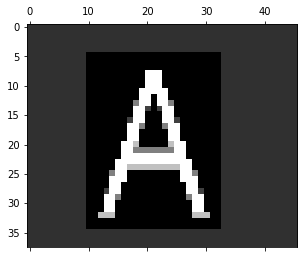

In [5]:
plt.matshow(arr_A_scaled)

In [6]:
arr_A_scaled[10]

array([0.19050343, 0.19050343, 0.19050343, 0.19050343, 0.19050343,
       0.19050343, 0.19050343, 0.19050343, 0.19050343, 0.19050343,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 1.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.19050343, 0.19050343,
       0.19050343, 0.19050343, 0.19050343, 0.19050343, 0.19050343,
       0.19050343, 0.19050343, 0.19050343, 0.19050343, 0.19050343,
       0.19050343])

In [9]:
data_1_0_scaled = ipm.scale(signal_1.data[0], 0.5, 0.8)

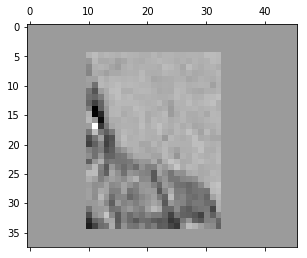

In [10]:
plt.matshow(data_1_0_scaled)

#### `optimise_scale(arr_moving: np.array, arr_ref: np.array, initial_guess_x=1.0, initial_guess_y=1.0)`

In [64]:
scale_optimisation_result = ipm.optimise_scale(arr_A, arr_A_scaled)

In [12]:
scale_optimisation_result.x

array([0.50048838, 0.80148497])

In [65]:
scale_x = scale_optimisation_result.x[0]
scale_y = scale_optimisation_result.x[1]
arr_A_scaled_2 = ipm.scale(arr_A, scale_x, scale_y)

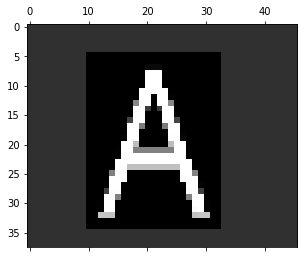

In [14]:
plt.matshow(arr_A_scaled_2)

#### Rigid registration + `optimise_scale`

In [66]:
shifts_2_v2 = ipm.estimate_shift_relative_to_most_representative_image(signal_2)
signal_2_shifted_v2 = hs.signals.Signal2D(np.empty_like(signal_2.data))
for t in range(signal_2.data.shape[0]):
    vfield = np.array([np.ones_like(signal_2.data[t]) * -shifts_2_v2[t][0], np.ones_like(signal_2.data[t]) * -shifts_2_v2[t][1]])
    signal_2_shifted_v2.data[t] = ipm.apply_displacement_field_sitk(vfield, signal_2.data[t])
max_mi_index = ipm.highest_mutual_information_index(signal_2_shifted_v2)
signal_2_shifted_v2_scaled = hs.signals.Signal2D(np.empty_like(signal_2.data))
scale_data = []
for t in range(signal_2.data.shape[0]):
    scale_result = ipm.optimise_scale(signal_2_shifted_v2.data[t], signal_2_shifted_v2.data[max_mi_index])
    signal_2_shifted_v2_scaled.data[t] = ipm.scale(signal_2_shifted_v2.data[t], scale_result.x[0], scale_result.x[1])
    scale_data.append(scale_result.x)

/dls_sw/apps/python/anaconda/1.7.0/64/envs/python3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


In [5]:
x_scales = np.array(scale_data).T[0]
y_scales = np.array(scale_data).T[1]

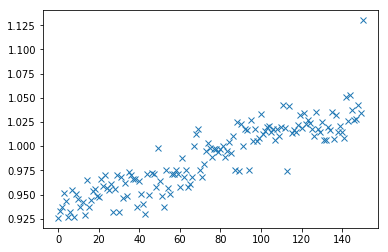

In [10]:
plt.plot(x_scales, 'x')

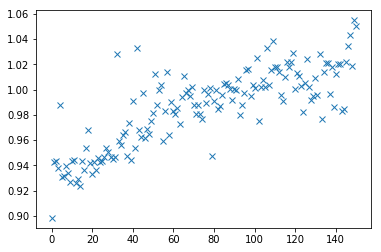

In [11]:
plt.plot(y_scales, 'x')

In [55]:
%matplotlib qt
hs.plot.plot_signals([signal_2, signal_2_shifted_v2_scaled])

In [67]:
signal_2_shifted_v2_scaled_nonrigid = hs.signals.Signal2D(ipm.nonrigid(signal_2_shifted_v2_scaled.data, demons_it = 20, filter_size = 5.0, max_it = 3, default_pixel_value = signal_2_shifted_v2_scaled.data[0].mean()))

#### Compare unmodified, shifted, shifted & scaled, shifted & scaled & nonrigid registered

In [68]:
%matplotlib qt
hs.plot.plot_signals([signal_2, signal_2_shifted_v2, signal_2_shifted_v2_scaled, signal_2_shifted_v2_scaled_nonrigid])

#### `rotate(arr_in: np.array, rotate_radians=0.0)`

In [4]:
arr_A_rotated = ipm.rotate(arr_A, math.pi/6)

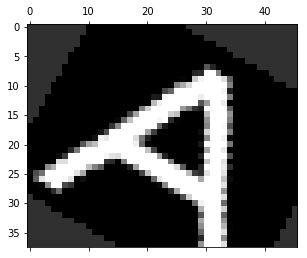

In [5]:
plt.matshow(arr_A_rotated)

#### `optimise_rotation(arr_moving: np.array, arr_ref: np.array, initial_guess_radians=0.1)`

In [14]:
rotation_optimisation_result = ipm.optimise_rotation(arr_A, arr_A_rotated)

In [15]:
rotation_optimisation_result.x

array([0.52359375])

In [16]:
arr_A_rotated_2 = ipm.rotate(arr_A, rotation_optimisation_result.x[0])

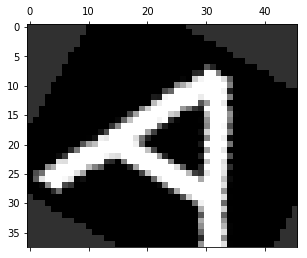

In [17]:
plt.matshow(arr_A_rotated_2)

In [58]:
arr_mi = np.empty((10,2))
max_rotate = math.pi/6
for i in range(10):
    arr_mi[i][0] = ipm.mutual_information(arr_A, ipm.rotate(arr_A, i*max_rotate/9))
    arr_mi[i][1] = ipm.mutual_information(ipm.rotate(arr_A, max_rotate), ipm.rotate(arr_A, i*max_rotate/9))    

In [59]:
arr_mi

array([[1.        , 0.02772298],
       [0.39143276, 0.07564718],
       [0.24887735, 0.10688139],
       [0.16992909, 0.15212583],
       [0.11948464, 0.21263226],
       [0.07781172, 0.2760689 ],
       [0.05414335, 0.37488864],
       [0.0468971 , 0.48411249],
       [0.03437141, 0.63370722],
       [0.02772298, 1.        ]])

#### `affine(arr_in: np.array, rotate_radians=0.0, scale_x=1.0, scale_y=1.0, shear_x=0.0, shear_y=0.0, offset_x=0.0, offset_y=0.0)`

In [4]:
arr_A_affine = ipm.affine(arr_A, rotate_radians=math.pi/6, scale_x=0.5, scale_y=1.1, shear_x=0.5, shear_y=0.0, offset_x=0.0, offset_y=0.0)

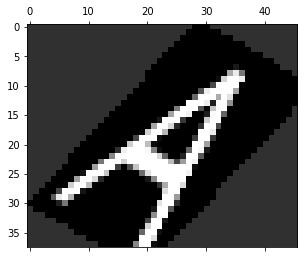

In [5]:
plt.matshow(arr_A_affine)

#### `optimise_affine(arr_moving: np.array, arr_ref: np.array, rotate_radians=0.1, scale_x=1.0, scale_y=1.0, shear_x=0.0, shear_y=0.0, offset_x=0.0, offset_y=0.0)`

In [8]:
import scipy

In [9]:
def optimise_affine_v3(arr_moving: np.array, arr_ref: np.array, rotate_radians=0.1, scale_x=1.0, scale_y=1.0, shear_x=0.0, shear_y=0.0, offset_x=0.0, offset_y=0.0):
    def inverse_mutual_information_after_transform(parameters):
        arr_transformed = ipm.affine(arr_moving, rotate_radians=parameters[0], scale_x=parameters[1], scale_y=parameters[2], shear_x=parameters[3], shear_y=parameters[4], offset_x=parameters[5], offset_y=parameters[6])
        return 1/ipm.mutual_information(arr_transformed, arr_ref)
    optimisation_result = scipy.optimize.minimize(inverse_mutual_information_after_transform, [rotate_radians, scale_x, scale_y, shear_x, shear_y, offset_x, offset_y], method='Nelder-Mead')
    #optimisation_result = scipy.optimize.basinhopping(inverse_mutual_information_after_transform, [rotate_radians, scale_x, scale_y, shear_x, shear_y, offset_x, offset_y], niter=10000, niter_success=10, T=10.0)
    max_scale = 5
    max_translate_factor=0.2
    #optimisation_result = scipy.optimize.differential_evolution(inverse_mutual_information_after_transform, [(-math.pi, math.pi), (-max_scale, max_scale), (-max_scale, max_scale), (-math.pi, math.pi), (-math.pi, math.pi), (-arr_moving.shape[0]*max_translate_factor, arr_moving.shape[0]*max_translate_factor), (-arr_moving.shape[1]*max_translate_factor, arr_moving.shape[1]*max_translate_factor)])
    
    #optimisation_result = scipy.optimize.minimize(inverse_mutual_information_after_transform, [rotate_radians, scale_x, scale_y, shear_x, shear_y, offset_x, offset_y], method='L-BFGS-B')
    return optimisation_result

def optimise_affine_v4(arr_moving: np.array, arr_ref: np.array, rotate_radians=0.1, scale_x=1.0, scale_y=1.0, shear_x=0.0, shear_y=0.0, offset_x=0.0, offset_y=0.0):
    def difference_after_transform(parameters):
        arr_transformed = ipm.affine(arr_moving, rotate_radians=parameters[0], scale_x=parameters[1], scale_y=parameters[2], shear_x=parameters[3], shear_y=parameters[4], offset_x=parameters[5], offset_y=parameters[6])
        return abs(arr_transformed - arr_ref).mean()
    optimisation_result = scipy.optimize.minimize(difference_after_transform, [rotate_radians, scale_x, scale_y, shear_x, shear_y, offset_x, offset_y], method='Nelder-Mead')
    #optimisation_result = scipy.optimize.basinhopping(difference_after_transform, [rotate_radians, scale_x, scale_y, shear_x, shear_y, offset_x, offset_y], niter=10000, niter_success=10, T=1.0)
    return optimisation_result

In [10]:
#affine_optimisation_result_1 = ipm.optimise_affine(arr_A, arr_A_affine, rotate_radians=math.pi/4, offset_x=10.0, offset_y=10.0)
affine_optimisation_result_1 = optimise_affine_v3(arr_A, arr_A_affine, rotate_radians=math.pi/4, offset_x=0.0, offset_y=0.0)

In [11]:
affine_optimisation_result_1.x

array([7.46638011e-01, 4.87387572e-01, 1.16502390e+00, 6.06404530e-04,
       1.24668359e-04, 5.38830031e-05, 1.33391209e-03])

In [12]:
arr_A_affine_2 = ipm.affine(arr_A, rotate_radians=affine_optimisation_result_1.x[0], scale_x=affine_optimisation_result_1.x[1], scale_y=affine_optimisation_result_1.x[2], shear_x=affine_optimisation_result_1.x[3], shear_y=affine_optimisation_result_1.x[4], offset_x=affine_optimisation_result_1.x[5], offset_y=affine_optimisation_result_1.x[6])

In [13]:
[ipm.mutual_information(arr_A_affine, arr_A_affine_2), ipm.mutual_information(arr_A, arr_A_affine_2), ipm.mutual_information(arr_A_affine, arr_A), ipm.mutual_information(arr_A_affine, arr_A_affine)]

[0.7659035566969455,
 0.04330696987023428,
 0.04260515038296682,
 1.0000000000000002]

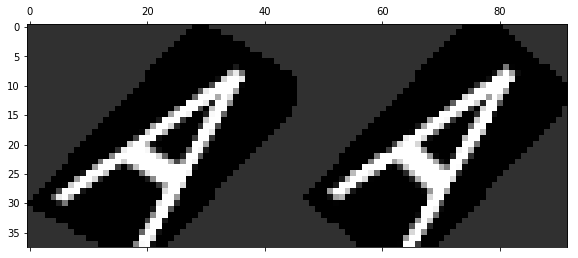

In [15]:
plt.matshow(np.hstack((arr_A_affine, arr_A_affine_2)))

#### `optimise_affine_v2(arr_moving: np.array, arr_ref: np.array, scale_x=1.0, scale_y=1.0, shear_radians=0.0, rotate_radians=0.0, offset_x=0.0, offset_y=0.0)`

In [6]:
#arr_A_affine_v2 = ipm.affine(arr_A, rotate_radians=math.pi/6, scale_x=0.5, scale_y=1.1, shear_x=0.0, shear_y=0.0, offset_x=0.0, offset_y=0.0)
scale_x=0.5
scale_y=1.1
shear_radians=math.pi/4
rotate_radians=-math.pi/5
#offset_x=24.0
#offset_y=-5.0
offset_x = 5.9
offset_y = 1.4
arr_A_affine_v2 = ipm.transform_using_values(arr_A, [scale_x, scale_y, shear_radians, rotate_radians, offset_x, offset_y])
#[a0, a1, a2, b0, b1, b2] = [scale_x * math.cos(rotate_radians), -scale_y * math.sin(rotate_radians + shear_radians), offset_x, scale_x * math.sin(rotate_radians), scale_y * math.cos(rotate_radians + shear_radians), offset_y]
#arr_A_affine_v2 = skimage.transform.warp(arr_A, skimage.transform.AffineTransform(matrix=np.array([[a0, a1, a2], [b0, b1, b2], [0, 0, 1]])).inverse)

In [7]:
plt.matshow(arr_A_affine_v2)

In [15]:
import scipy

In [19]:
def optimise_affine_v2(arr_moving: np.array, arr_ref: np.array, scale_x=1.0, scale_y=1.0, shear_radians=0.0, rotate_radians=0.0, offset_x=0.0, offset_y=0.0):
    def inverse_mutual_information_after_transform(parameters):
        transform = skimage.transform.AffineTransform(matrix=np.array([[parameters[0], parameters[1], parameters[2]], [parameters[3], parameters[4], parameters[5]], [0, 0, 1]]))
        arr_transformed = skimage.transform.warp(arr_moving, transform.inverse)
        return 1/ipm.mutual_information(arr_transformed, arr_ref)
    max_scale = 5
    max_translate_factor = 0.2
    # min: -max_scale, max: max_scale
    a0 = scale_x * math.cos(rotate_radians)
    # min: -max_scale, max: max_scale
    a1 = -scale_y * math.sin(rotate_radians + shear_radians)
    # min: -arr_moving.shape[0], max: arr_moving.shape[0]
    a2 = offset_x
    # min: -max_scale, max: max_scale
    b0 = scale_x * math.sin(rotate_radians)
    # min: -max_scale, max: max_scale
    b1 = scale_y * math.cos(rotate_radians + shear_radians)
    # min: -arr_moving.shape[1], max: arr_moving.shape[1]
    b2 = offset_y
    optimisation_result = scipy.optimize.minimize(inverse_mutual_information_after_transform, [a0, a1, a2, b0, b1, b2], method='Nelder-Mead')
    #optimisation_result = scipy.optimize.basinhopping(inverse_mutual_information_after_transform, [a0, a1, a2, b0, b1, b2], niter=10000, niter_success=10, T=10.0)
    #optimisation_result = scipy.optimize.differential_evolution(inverse_mutual_information_after_transform, [(-max_scale, max_scale), (-max_scale, max_scale), (-arr_moving.shape[0]*max_translate_factor, arr_moving.shape[0]*max_translate_factor), (-max_scale, max_scale), (-max_scale, max_scale), (-arr_moving.shape[1]*max_translate_factor, arr_moving.shape[1]*max_translate_factor)])
    return optimisation_result

def optimise_affine_v5(arr_moving: np.array, arr_ref: np.array, scale_x=1.0, scale_y=1.0, shear_radians=0.0, rotate_radians=0.0, offset_x=0.0, offset_y=0.0):
    def inverse_mutual_information_after_transform(parameters):
        arr_transformed = ipm.transform_using_values(arr_moving, parameters)
        return 1/ipm.mutual_information(arr_transformed, arr_ref)
    #optimisation_result = scipy.optimize.minimize(inverse_mutual_information_after_transform, [scale_x, scale_y, shear_radians, rotate_radians, offset_x, offset_y], method='Nelder-Mead')
    #optimisation_result = scipy.optimize.basinhopping(inverse_mutual_information_after_transform, [scale_x, scale_y, shear_radians, rotate_radians, offset_x, offset_y], niter=10000, niter_success=10, T=0.1)
    max_scale = 5
    max_translate_factor=0.2
    # differential_evolution works well for the parameter values [0.5, 1.1, 0.0, math.pi/6, 3.0, -5.0].
    optimisation_result = scipy.optimize.differential_evolution(inverse_mutual_information_after_transform, [(1/max_scale, max_scale), (1/max_scale, max_scale), (-math.pi/3, math.pi/3), (-math.pi, math.pi), (-arr_moving.shape[0]*max_translate_factor, arr_moving.shape[0]*max_translate_factor), (-arr_moving.shape[1]*max_translate_factor, arr_moving.shape[1]*max_translate_factor)])
    #optimisation_result = scipy.optimize.minimize(inverse_mutual_information_after_transform, [scale_x, scale_y, shear_radians, rotate_radians, offset_x, offset_y], method='L-BFGS-B')
    return optimisation_result

In [13]:
def optimise_affine_by_differential_evolution(arr_moving: np.array, arr_ref: np.array, bounds=None, maxiter=1000):
    def inverse_mutual_information_after_transform(parameters):
        return 1/ipm.mutual_information(ipm.transform_using_values(arr_moving, parameters), arr_ref)
    if bounds is None:
        max_scale_factor = 2
        max_translate_factor = 0.2
        bounds = [(1/max_scale_factor, max_scale_factor), (1/max_scale_factor, max_scale_factor), (-math.pi/3, math.pi/3), (-math.pi/3, math.pi/3), (-arr_moving.shape[0]*max_translate_factor, arr_moving.shape[0]*max_translate_factor), (-arr_moving.shape[1]*max_translate_factor, arr_moving.shape[1]*max_translate_factor)]
    assert bounds[0][0] >= 0
    #assert bounds[0][1] >= max(bounds[0][0], 1)
    assert bounds[0][1] >= bounds[0][0]
    assert bounds[1][0] >= 0
    #assert bounds[1][1] >= max(bounds[1][0], 1)
    assert bounds[1][1] >= bounds[1][0]
    assert abs(bounds[2][0]) < math.pi/2
    assert abs(bounds[2][1]) < math.pi/2 and bounds[2][1] >= bounds[2][0]
    assert abs(bounds[3][0]) <= math.pi
    assert abs(bounds[3][1]) <= math.pi and bounds[3][1] >= bounds[3][0]
    assert abs(bounds[4][0]) <= arr_moving.shape[0]
    assert abs(bounds[4][1]) <= arr_moving.shape[0] and bounds[4][1] >= bounds[4][0]
    assert abs(bounds[5][0]) <= arr_moving.shape[1]
    assert abs(bounds[5][1]) <= arr_moving.shape[1] and bounds[5][1] >= bounds[5][0]
    de_result = scipy.optimize.differential_evolution(inverse_mutual_information_after_transform, bounds, maxiter=maxiter)
    inv_mi_no_transform = inverse_mutual_information_after_transform([1, 1, 0, 0, 0, 0])
    inv_mi = inverse_mutual_information_after_transform(de_result.x)
    if inv_mi_no_transform <= inv_mi:
        de_result.x = [1, 1, 0, 0, 0, 0]
    return de_result

In [13]:
#affine_optimisation_result_2 = optimise_affine_v5(arr_A, arr_A_affine_v2, rotate_radians=math.pi/4, shear_radians=math.pi/4, offset_x=3, offset_y=3)
affine_optimisation_result_2 = optimise_affine_by_differential_evolution(arr_A, arr_A_affine_v2, maxiter=100)

In [14]:
[scale_x, scale_y, shear_radians, rotate_radians, offset_x, offset_y]

[0.5, 1.1, 0.7853981633974483, -0.6283185307179586, 5.9, 1.4]

In [15]:
affine_optimisation_result_2.x

array([ 0.50328645,  1.10166607,  0.78950081, -0.63181475,  5.89521458,
        1.41347075])

In [16]:
arr_A_affine_3 = ipm.transform_using_values(arr_A, affine_optimisation_result_2.x)

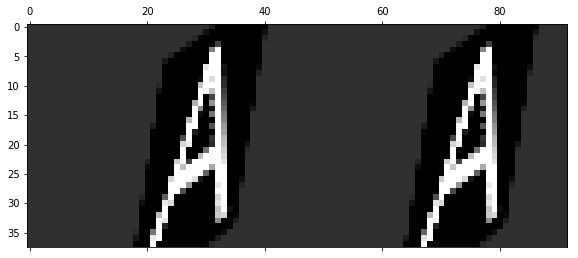

In [17]:
plt.matshow(np.hstack((arr_A_affine_3, arr_A_affine_v2)))

In [24]:
def optimise_signal_affine(signal_in: hs.signals.Signal2D, bounds=None, maxiter=1000):
    parameters = np.empty((signal_in.data.shape[0], 6))
    index_ref = ipm.highest_mutual_information_index(signal_in)
    arr_ref = signal_in.data[index_ref]
    for t in range(signal_in.data.shape[0]):
        parameters[t] = optimise_affine_by_differential_evolution(signal_in.data[t], arr_ref, bounds=bounds, maxiter=maxiter).x
    return parameters

def optimise_signal_affine_v2(signal_in: hs.signals.Signal2D, bounds=None, maxiter=1000):
    parameters = np.empty((signal_in.data.shape[0], 6))
    index_ref = ipm.highest_mutual_information_index(signal_in)
    arr_ref = signal_in.data[index_ref]
    
    # data_pre: all elements up to and including index_ref, reversed
    data_pre = signal_in.data[:index_ref+1][::-1]
    assert data_pre.shape[0] == index_ref + 1
    # data_post: all elements from index_ref onwards
    data_post = signal_in.data[index_ref:]
    assert data_post.shape[0] == signal_in.data.shape[0] - index_ref
    
    if bounds is None:
        #max_scale_factor = 2
        #max_translate_factor = 0.2
        #bounds = [
        #    (1/max_scale_factor, max_scale_factor), 
        #    (1/max_scale_factor, max_scale_factor), 
        #    (-math.pi/3, math.pi/3), 
        #    (-math.pi/3, math.pi/3), 
        #    (-arr_moving.shape[0]*max_translate_factor, arr_moving.shape[0]*max_translate_factor), 
        #    (-arr_moving.shape[1]*max_translate_factor, arr_moving.shape[1]*max_translate_factor)]
        max_consecutive_scale_factor = 1.1
        max_consecutive_shear = math.pi/36 # 5 degrees
        max_consecutive_rotate = math.pi/36 # 5 degrees
        max_consecutive_translate_factor = 0.05
        bounds = [
            (1/max_consecutive_scale_factor, max_consecutive_scale_factor),
            (1/max_consecutive_scale_factor, max_consecutive_scale_factor),
            (-max_consecutive_shear, max_consecutive_shear),
            (-max_consecutive_rotate, max_consecutive_rotate),
            (-arr_ref.shape[0]*max_consecutive_translate_factor, arr_ref.shape[0]*max_consecutive_translate_factor),
            (-arr_ref.shape[1]*max_consecutive_translate_factor, arr_ref.shape[1]*max_consecutive_translate_factor)]
    
    bounds_current = bounds
    
    def within_bounds(bounds_min, bounds_max, value):
        assert bounds_max >= bounds_min
        return max(bounds_min, min(bounds_max, value))
    
    def adjust_bounds_to_parameters(bounds_current, parameters):
        assert parameters[0] >= bounds_current[0][0]
        assert parameters[0] <= bounds_current[0][1]
        assert parameters[1] >= bounds_current[1][0]
        assert parameters[1] <= bounds_current[1][1]
        assert parameters[2] >= bounds_current[2][0]
        assert parameters[2] <= bounds_current[2][1]
        assert parameters[3] >= bounds_current[3][0]
        assert parameters[3] <= bounds_current[3][1]
        assert parameters[4] >= bounds_current[4][0]
        assert parameters[4] <= bounds_current[4][1]
        assert parameters[5] >= bounds_current[5][0]
        assert parameters[5] <= bounds_current[5][1]
        max_scale_factor = 2
        max_translate_factor = 0.2
        assert bounds_current[0][0] >= 1/max_scale_factor
        assert bounds_current[0][0] <= max_scale_factor
        assert bounds_current[0][1] >= 1/max_scale_factor
        assert bounds_current[0][1] <= max_scale_factor
        assert bounds_current[1][0] >= 1/max_scale_factor
        assert bounds_current[1][0] <= max_scale_factor
        assert bounds_current[1][1] >= 1/max_scale_factor
        assert bounds_current[1][1] <= max_scale_factor
        assert abs(bounds_current[2][0]) <= math.pi/3
        assert abs(bounds_current[2][1]) <= math.pi/3
        assert abs(bounds_current[3][0]) <= math.pi/3
        assert abs(bounds_current[3][1]) <= math.pi/3
        scale_x_min_next = within_bounds(1/max_scale_factor, max_scale_factor, parameters[0] * bounds_current[0][0])
        scale_x_max_next = within_bounds(1/max_scale_factor, max_scale_factor, parameters[0] * bounds_current[0][1])
        scale_y_min_next = within_bounds(1/max_scale_factor, max_scale_factor, parameters[1] * bounds_current[1][0])
        scale_y_max_next = within_bounds(1/max_scale_factor, max_scale_factor, parameters[1] * bounds_current[1][1])
        shear_min_next = within_bounds(-math.pi/3, math.pi/3, parameters[2] + bounds_current[2][0])
        shear_max_next = within_bounds(-math.pi/3, math.pi/3, parameters[2] + bounds_current[2][1])
        rotate_min_next = within_bounds(-math.pi/3, math.pi/3, parameters[3] + bounds_current[3][0])
        rotate_max_next = within_bounds(-math.pi/3, math.pi/3, parameters[3] + bounds_current[3][1])
        offset_x_min_next = within_bounds(-arr_ref.shape[0]*max_translate_factor, arr_ref.shape[0]*max_translate_factor, parameters[4] + bounds_current[4][0])
        offset_x_max_next = within_bounds(-arr_ref.shape[0]*max_translate_factor, arr_ref.shape[0]*max_translate_factor, parameters[4] + bounds_current[4][1])
        offset_y_min_next = within_bounds(-arr_ref.shape[1]*max_translate_factor, arr_ref.shape[1]*max_translate_factor, parameters[5] + bounds_current[5][0])
        offset_y_max_next = within_bounds(-arr_ref.shape[1]*max_translate_factor, arr_ref.shape[1]*max_translate_factor, parameters[5] + bounds_current[5][1])
        bounds_00 = min(scale_x_min_next, scale_x_max_next)
        bounds_01 = max(scale_x_min_next, scale_x_max_next)
        bounds_10 = min(scale_y_min_next, scale_y_max_next)
        bounds_11 = max(scale_y_min_next, scale_y_max_next)
        bounds_20 = min(shear_min_next, shear_max_next)
        bounds_21 = max(shear_min_next, shear_max_next)
        bounds_30 = min(rotate_min_next, rotate_max_next)
        bounds_31 = max(rotate_min_next, rotate_max_next)
        bounds_40 = min(offset_x_min_next, offset_x_max_next)
        bounds_41 = max(offset_x_min_next, offset_x_max_next)
        bounds_50 = min(offset_y_min_next, offset_y_max_next)
        bounds_51 = max(offset_y_min_next, offset_y_max_next)
        return [(bounds_00, bounds_01), (bounds_10, bounds_11), (bounds_20, bounds_21), (bounds_30, bounds_31), (bounds_40, bounds_41), (bounds_50, bounds_51)]
            
    for t in range(data_pre.shape[0]):
        parameters[index_ref - t] = optimise_affine_by_differential_evolution(data_pre[t], arr_ref, bounds=bounds_current, maxiter=maxiter).x
        assert parameters[index_ref - t][0] >= bounds_current[0][0]
        assert parameters[index_ref - t][0] <= bounds_current[0][1]
        assert parameters[index_ref - t][1] >= bounds_current[1][0]
        assert parameters[index_ref - t][1] <= bounds_current[1][1]
        assert parameters[index_ref - t][2] >= bounds_current[2][0]
        assert parameters[index_ref - t][2] <= bounds_current[2][1]
        assert parameters[index_ref - t][3] >= bounds_current[3][0]
        assert parameters[index_ref - t][3] <= bounds_current[3][1]
        assert parameters[index_ref - t][4] >= bounds_current[4][0]
        assert parameters[index_ref - t][4] <= bounds_current[4][1]
        assert parameters[index_ref - t][5] >= bounds_current[5][0]
        assert parameters[index_ref - t][5] <= bounds_current[5][1]
        bounds_current = adjust_bounds_to_parameters(bounds_current, parameters[index_ref - t])
        
    bounds_current = bounds
    
    for t in range(data_post.shape[0]):
        parameters[index_ref + t] = optimise_affine_by_differential_evolution(data_post[t], arr_ref, bounds=bounds_current, maxiter=maxiter).x
        bounds_current = adjust_bounds_to_parameters(bounds_current, parameters[index_ref + t])
        
    return parameters

def optimise_signal_affine_v3(signal_in: hs.signals.Signal2D, bounds=None, maxiter=1000):
    parameters = np.empty((signal_in.data.shape[0], 6))
    index_ref = ipm.highest_mutual_information_index(signal_in)
    arr_ref = signal_in.data[index_ref]
    
    # data_pre: all elements up to and including index_ref, reversed
    data_pre = signal_in.data[:index_ref+1][::-1]
    assert data_pre.shape[0] == index_ref + 1
    # data_post: all elements from index_ref onwards
    data_post = signal_in.data[index_ref:]
    assert data_post.shape[0] == signal_in.data.shape[0] - index_ref
    
    for t in range(data_pre.shape[0]):
        parameters[index_ref - t] = optimise_affine_by_differential_evolution(data_pre[t], arr_ref, bounds=bounds, maxiter=maxiter).x
        arr_ref = ipm.transform_using_values(data_pre[t], parameters[index_ref - t])
    arr_ref = signal_in.data[index_ref]
    for t in range(data_post.shape[0]):
        parameters[index_ref + t] = optimise_affine_by_differential_evolution(data_post[t], arr_ref, bounds=bounds, maxiter=maxiter).x
        arr_ref = ipm.transform_using_values(data_post[t], parameters[index_ref + t])
    return parameters

def transform_signal_affine(signal_in: hs.signals.Signal2D, parameters: np.array):
    signal_out = hs.signals.Signal2D(np.empty_like(signal_in.data))
    for t in range(signal_in.data.shape[0]):
        signal_out.data[t] = ipm.transform_using_values(signal_in.data[t], parameters[t])
    return signal_out

In [5]:
index_ref_A = ipm.highest_mutual_information_index(signal_A)
index_ref_A

1

In [23]:
parameters_affine_A_v2 = optimise_signal_affine_v2(signal_A, maxiter=100)

In [24]:
parameters_affine_A_v2[index_ref_A]

array([1., 1., 0., 0., 0., 0.])

In [25]:
signal_affine_A = transform_signal_affine(signal_A, parameters_affine_A_v2)

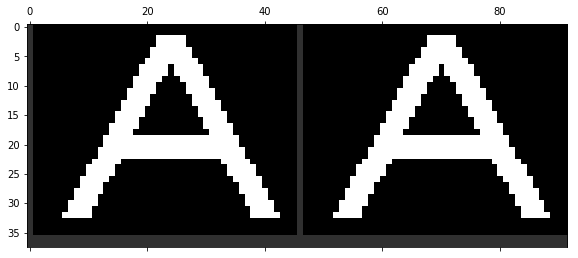

In [26]:
plt.matshow(np.hstack((signal_A.data[index_ref_A], signal_affine_A.data[index_ref_A])))

In [30]:
index_ref_2 = ipm.highest_mutual_information_index(signal_2)
index_ref_2

66

In [28]:
parameters_affine_2 = optimise_signal_affine(signal_2, maxiter=100)

In [40]:
parameters_affine_2_v2 = optimise_signal_affine_v3(signal_2, maxiter=100)

In [31]:
parameters_affine_2[index_ref_2]

array([1., 1., 0., 0., 0., 0.])

In [41]:
parameters_affine_2_v2[index_ref_2]

array([1., 1., 0., 0., 0., 0.])

In [32]:
signal_affine_2 = transform_signal_affine(signal_2, parameters_affine_2)

In [42]:
signal_affine_2_v2 = transform_signal_affine(signal_2, parameters_affine_2_v2)

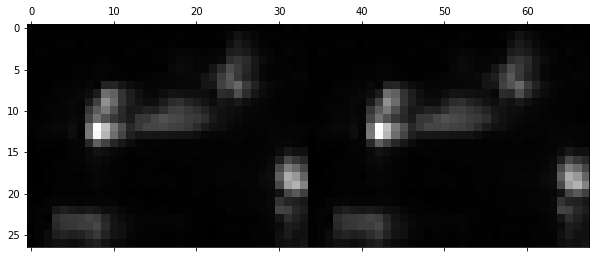

In [33]:
plt.matshow(np.hstack((signal_2.data[index_ref_2], signal_affine_2.data[index_ref_2])))

In [43]:
plt.matshow(np.hstack((signal_2.data[index_ref_2], signal_affine_2_v2.data[index_ref_2])))

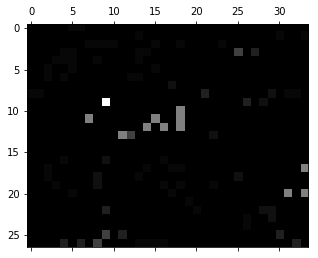

In [34]:
plt.matshow(abs(signal_2.data[index_ref_2] - signal_affine_2.data[index_ref_2]))

In [35]:
[abs(signal_2.data[index_ref_2] - signal_affine_2.data[index_ref_2]).min(), abs(signal_2.data[index_ref_2] - signal_affine_2.data[index_ref_2]).mean(), abs(signal_2.data[index_ref_2] - signal_affine_2.data[index_ref_2]).max()]

[0.0003046158087371964, 3.079401214529603, 56.12428907599384]

In [36]:
[[signal_2.data[index_ref_2].min(), signal_affine_2.data[index_ref_2].min()], [signal_2.data[index_ref_2].mean(), signal_affine_2.data[index_ref_2].mean()], [signal_2.data[index_ref_2].max(), signal_affine_2.data[index_ref_2].max()]]

[[28.91828846919111, 30.007113605580916],
 [237.02318365004902, 237.36775082260374],
 [3515.6187195660495, 3492.90136112175]]

In [35]:
%matplotlib qt
hs.plot.plot_signals([signal_2, signal_affine_2])

In [1]:
%matplotlib qt
hs.plot.plot_signals([signal_2, signal_affine_2_v2])

NameError: name 'hs' is not defined

In [16]:
parameters_affine_4 = optimise_signal_affine(signal_4, maxiter=100)

In [38]:
signal_affine_4 = transform_signal_affine(signal_4, parameters_affine_4)

In [39]:
index_ref_4 = ipm.highest_mutual_information_index(signal_4)
index_ref_4

18

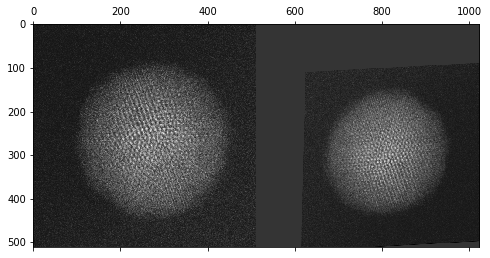

In [40]:
plt.matshow(np.hstack((signal_4.data[index_ref_4], signal_affine_4.data[index_ref_4])))

In [21]:
[ipm.mutual_information(signal_4.data[index_ref_4], signal_4.data[index_ref_4]), ipm.mutual_information(signal_affine_4.data[index_ref_4], signal_4.data[index_ref_4])]

[1.0, 0.2950792523985621]

In [6]:
parameters_affine_4_precomputed = np.array([[ 7.77675658e-01,  7.85193237e-01, -3.17242583e-02,
        -3.12868498e+00,  5.10765035e+01,  4.20837028e+01],
       [ 6.33119974e-01,  6.48271344e-01,  1.28332434e-02,
         7.62611439e-01,  2.65029800e+01,  1.53910101e+01],
       [ 6.38870427e-01,  6.25628628e-01, -2.57320894e-02,
         7.83898424e-01,  2.61202773e+01,  1.65801510e+01],
       [ 7.63451187e-01,  8.22426838e-01,  6.81061995e-02,
         3.02260569e+00,  4.69718832e+01,  5.16039817e+01],
       [ 6.25947693e-01,  6.32132277e-01, -7.63741067e-02,
         7.29988049e-01,  2.37473752e+01,  1.41929872e+01],
       [ 8.18593463e-01,  8.34825057e-01,  7.10684543e-02,
         3.00560646e+00,  5.08027756e+01,  3.89271654e+01],
       [ 7.41094305e-01,  7.92722688e-01,  5.89671993e-02,
         2.99325077e+00,  4.71147345e+01,  4.36558393e+01],
       [ 7.38544587e-01,  8.19356074e-01,  2.02270709e-02,
         2.98378992e+00,  5.06572601e+01,  4.72992017e+01],
       [ 8.03376519e-01,  7.68033569e-01,  9.91949945e-02,
        -3.06635642e+00,  5.97341150e+01,  4.34655930e+01],
       [ 6.45873334e-01,  6.46927553e-01, -3.08440343e-02,
         7.14363190e-01,  2.56569089e+01,  1.18748347e+01],
       [ 7.49189241e-01,  8.04652553e-01,  4.36718676e-02,
         3.00973958e+00,  5.17517950e+01,  4.49838255e+01],
       [ 7.69220257e-01,  8.23565862e-01,  5.21976413e-02,
         2.97651339e+00,  5.53185062e+01,  4.87370368e+01],
       [ 8.43309952e-01,  7.64370168e-01, -1.72447827e-02,
        -2.95163373e+00,  5.77412237e+01,  4.40856560e+01],
       [ 7.91813262e-01,  7.58612062e-01,  1.20675229e-02,
        -2.94404297e+00,  5.26165936e+01,  3.92424461e+01],
       [ 7.78595974e-01,  7.77980755e-01,  4.34897907e-02,
         2.94497519e+00,  5.50179790e+01,  3.84733268e+01],
       [ 8.35541208e-01,  8.57667789e-01,  7.96660703e-02,
         3.06402301e+00,  6.39011830e+01,  4.85660801e+01],
       [ 8.64640712e-01,  7.66698910e-01, -7.39610801e-02,
        -2.99261621e+00,  6.93488747e+01,  4.44823969e+01],
       [ 8.19869642e-01,  7.17442987e-01,  5.53207474e-02,
        -2.42741314e+00,  5.13262691e+01,  4.93640315e+01],
       [ 7.79590078e-01,  7.60700944e-01, -3.86649348e-02,
        -3.06900255e+00,  5.60686296e+01,  4.09937591e+01],
       [ 8.23104783e-01,  8.16914362e-01,  7.22315476e-02,
         3.00551161e+00,  6.65390548e+01,  4.66560698e+01]])

In [29]:
signal_affine_4_precomputed = transform_signal_affine(signal_4, parameters_affine_4_precomputed)

In [11]:
parameters_affine_4_A = np.array(parameters_affine_4_precomputed)
for i in range(len(parameters_affine_4_precomputed)):
    parameters_affine_4_A[i][4] = parameters_affine_4_precomputed[i][4] * (arr_A.shape[1]/signal_4.data.shape[2])
    parameters_affine_4_A[i][5] = parameters_affine_4_precomputed[i][5] * (arr_A.shape[0]/signal_4.data.shape[1])

In [12]:
signal_A_x20 = hs.signals.Signal2D(np.empty((signal_4.data.shape[0], arr_A.shape[0], arr_A.shape[1])))
for t in range(signal_4.data.shape[0]):
    signal_A_x20.data[t] = arr_A

In [15]:
signal_A_x20_transformed = transform_signal_affine(signal_A_x20, parameters_affine_4_A)

In [30]:
%matplotlib qt
hs.plot.plot_signals([signal_4, signal_affine_4_precomputed, signal_A_x20_transformed])

In [26]:
plt.matshow(np.hstack((signal_4.data[0], transform_using_values(signal_4.data[0]/signal_4.data[0].max(), parameters_affine_4_precomputed[0])*signal_4.data[0].max())))

In [23]:
signal_4.data[0]

array([[ 46415,  49245,  41267, ...,  54410,  63401,  42630],
       [ 64586,  55420,  42795, ...,  59002,  49869,  73122],
       [ 49558,  46429,  41782, ...,  52892,  54425,  45268],
       ...,
       [ 65949,  49356,  63305, ...,  70090,  56536,  63418],
       [ 48407,  44730,  51716, ...,  60239,  49369, 101490],
       [ 50542,  81756,  69079, ...,  72702,  59571,  65464]],
      dtype=uint32)

#### 'Pyramid' strategy

In [17]:
def resize_signal(signal_in: hs.signals.Signal2D, new_height: int, new_width: int):
    signal_out = hs.signals.Signal2D(np.empty((signal_in.data.shape[0], new_height, new_width)))
    for t in range(signal_in.data.shape[0]):
        signal_out.data[t] = skimage.transform.resize(signal_in.data[t], (new_height, new_width), mode='reflect', anti_aliasing=True)
    return signal_out

def transform_using_matrix(arr_in: np.array, matrix):
    tform = skimage.transform.AffineTransform(matrix=matrix)
    return skimage.transform.warp(arr_in/arr_in.max(), tform.inverse, cval=arr_in.mean()/arr_in.max())*arr_in.max()

def registration_method_default(arr_moving: np.array, arr_ref: np.array, bounds=None, maxiter=1000):
    return optimise_affine_by_differential_evolution(arr_moving, arr_ref, bounds=bounds, maxiter=maxiter).x

def pyramid_affine(arr_moving: np.array, arr_ref: np.array, num_levels=3, registration_method=registration_method_default, reg_args=None):
    # parameters = registration_method(arr_moving, arr_ref, *reg_args)
    (height, width) = arr_moving.data.shape
    tform_matrix = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    #tform = skimage.transform.AffineTransform(matrix=np.array([[a0, a1, a2], [b0, b1, b2], [0, 0, 1]]))
    for n in range(num_levels):
        power_of_2 = num_levels - 1 - n
        (new_height, new_width) = (max(1, height//(2**power_of_2)), max(1, width//(2**power_of_2)))
        (arr_moving_downsampled, arr_ref_downsampled) = (transform_using_matrix(arr_moving, tform_matrix), arr_ref)
        if power_of_2 > 0:
            arr_moving_downsampled = skimage.transform.resize(arr_moving_downsampled, (new_height, new_width), mode='reflect', anti_aliasing=True)
            arr_ref_downsampled = skimage.transform.resize(arr_ref_downsampled, (new_height, new_width), mode='reflect', anti_aliasing=True)
        [scale_x, scale_y, shear, rotation, offset_x, offset_y] = registration_method(arr_moving_downsampled, arr_ref_downsampled, *reg_args)
        if power_of_2 > 0:
            # Computed offsets must be scaled up
            offset_x = offset_x * height/new_height
            offset_y = offset_y * width/new_width
        new_tform_matrix = np.array([
            [scale_x * math.cos(rotation), -scale_y * math.sin(rotation + shear), offset_x],
            [scale_x * math.sin(rotation), scale_y * math.cos(rotation + shear), offset_y], 
            [0, 0, 1]
        ])
        tform_matrix = np.matmul(new_tform_matrix, tform_matrix)
    a0 = tform_matrix[0][0]
    a1 = tform_matrix[0][1]
    a2 = tform_matrix[0][2]
    b0 = tform_matrix[1][0]
    b1 = tform_matrix[1][1]
    b2 = tform_matrix[1][2]
    scale_x = math.sqrt(a0**2 + b0**2)
    scale_y = math.sqrt(a1**2 + b1**2)
    rotation = math.atan2(b0, a0)
    shear = math.atan2(-a1, b1) - rotation
    offset_x = a2
    offset_y = b2
    return [scale_x, scale_y, shear, rotation, offset_x, offset_y]

def affine_signal(signal_in: hs.signals.Signal2D, registration_method, reg_args=None):
    parameters = np.empty((signal_in.data.shape[0], 6))
    index_ref = ipm.highest_mutual_information_index(signal_in)
    arr_ref = signal_in.data[index_ref]
    for t in range(signal_in.data.shape[0]):
        parameters[t] = registration_method(signal_in.data[t], arr_ref, *reg_args)
    return parameters

In [18]:
num_levels=3
max_consecutive_scale_factor = 1.1
max_consecutive_shear = math.pi/36 # 5 degrees
max_consecutive_rotate = math.pi/36 # 5 degrees
max_consecutive_translate_factor = 0.05
bounds = [
    (1/max_consecutive_scale_factor, max_consecutive_scale_factor),
    (1/max_consecutive_scale_factor, max_consecutive_scale_factor),
    (-max_consecutive_shear, max_consecutive_shear),
    (-max_consecutive_rotate, max_consecutive_rotate),
    (-arr_A.shape[0]*max_consecutive_translate_factor, arr_A.shape[0]*max_consecutive_translate_factor),
    (-arr_A.shape[1]*max_consecutive_translate_factor, arr_A.shape[1]*max_consecutive_translate_factor)]
maxiter = 100
params_pyramid_A = affine_signal(signal_A, pyramid_affine, reg_args=(num_levels, registration_method_default, (bounds, maxiter)))

In [19]:
bounds

[(0.9090909090909091, 1.1),
 (0.9090909090909091, 1.1),
 (-0.08726646259971647, 0.08726646259971647),
 (-0.08726646259971647, 0.08726646259971647),
 (-1.9000000000000001, 1.9000000000000001),
 (-2.3000000000000003, 2.3000000000000003)]

In [20]:
params_pyramid_A

array([[ 1.00174622,  0.99016487, -0.00894454,  0.00679667,  1.21003408,
        -2.3554975 ],
       [ 1.        ,  1.        , -0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.00240832,  1.01772405, -0.00613766,  0.00284131, -0.19755799,
         0.10906536]])

In [25]:
signal_pyramid_A = transform_signal_affine(signal_A, params_pyramid_A)

In [62]:
%matplotlib qt
hs.plot.plot_signals([signal_A, signal_pyramid_A])

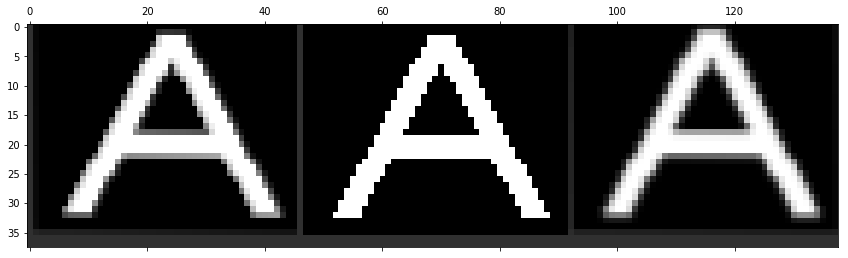

In [26]:
plt.matshow(np.hstack((signal_pyramid_A.data[0], signal_pyramid_A.data[1], signal_pyramid_A.data[2])))

#### "Simple" affine transformation: rotation and scaling only, scale_x = scale_y

In [11]:
scale_simple = 0.8
rotation_simple = -math.pi/12
#arr_A_affine_simple = skimage.transform.warp(arr_A, skimage.transform.AffineTransform(matrix=np.array([[scale_simple * math.cos(rotation_simple), -scale_simple * math.sin(rotation_simple), 0], [scale_simple * math.sin(rotation_simple), scale_simple * math.cos(rotation_simple), 0], [0, 0, 1]])).inverse)
arr_A_affine_simple = ipm.transform_using_values(arr_A, [scale_simple, scale_simple, 0, rotation_simple, 0, 0])

In [12]:
plt.matshow(arr_A_affine_simple)

#### Calculate mutual information between transformed arr_A and reference image pictured above, for a range of scale and rotation values

In [19]:
scale_min = 0.1
scale_max = 2
rotation_min = -math.pi
rotation_max = math.pi
num_scales = 100
num_rotations = 100
#tformed = np.array((num_scales, num_rotations, arr_A.shape[0], arr_A.shape[1]))
tformed = []
for i in range(num_scales):
    tformed.append([])
    scale_current = scale_min + (scale_max - scale_min) * i/(num_scales-1)
    for j in range(num_rotations):
        rotation_current = rotation_min + (rotation_max - rotation_min) * j/(num_rotations-1)
        #tformed[i][j] = skimage.transform.warp(arr_A, skimage.transform.AffineTransform(matrix=np.array([[scale_current * math.cos(rotation_current), -scale_current * math.sin(rotation_current), 0], [scale_current * math.sin(rotation_current), scale_current * math.cos(rotation_current), 0], [0, 0, 1]])).inverse)
        #tformed[i].append(skimage.transform.warp(arr_A, skimage.transform.AffineTransform(matrix=np.array([[scale_current * math.cos(rotation_current), -scale_current * math.sin(rotation_current), 0], [scale_current * math.sin(rotation_current), scale_current * math.cos(rotation_current), 0], [0, 0, 1]])).inverse))
        tformed[i].append(ipm.transform_using_values(arr_A, [scale_current, scale_current, 0, rotation_current, 0, 0]))
#tformed_mi = np.array((num_scales, num_rotations))
tformed_mi = []
for i in range(num_scales):
    tformed_mi.append([])
    for j in range(num_rotations):
        #tformed_mi[i][j] = ipm.mutual_information(tformed[i][j], arr_A_affine_simple)
        tformed_mi[i].append(ipm.mutual_information(tformed[i][j], arr_A_affine_simple))
arr_mi = np.array(tformed_mi)

#### Plot mutual information as calculated above (intensity) against scale factor (vertical axis) and rotation (horizontal axis)

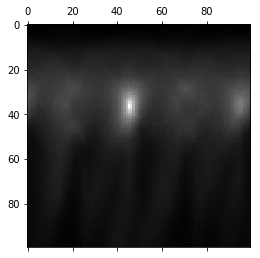

In [41]:
plt.matshow(arr_mi)

In [20]:
plt.matshow(arr_mi)

#### "Moving" image (left) and "reference" image (right)

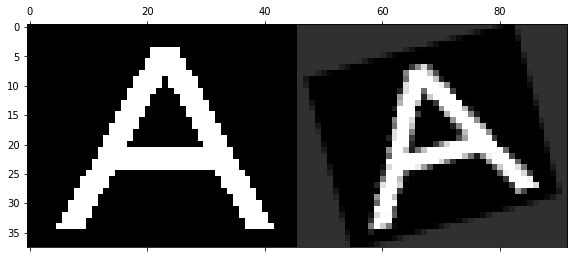

In [42]:
plt.matshow(np.hstack((arr_A, arr_A_affine_simple)))

#### Print estimated and true scale and rotation values
The values estimated are reasonably close to the true values.

In [43]:
(opt_i, opt_j) = np.unravel_index(np.argmax(arr_mi), arr_mi.shape)
opt_scale = scale_min + (scale_max - scale_min) * opt_i/num_scales
opt_rotation = rotation_min + (rotation_max - rotation_min) * opt_j/num_rotations
[[opt_scale, opt_rotation], [scale_simple, rotation_simple]]

[[0.7839999999999999, -0.3141592653589793], [0.8, -0.2617993877991494]]

#### Compare mutual information between transformed image and reference image with the MI of the reference image with itself

In [44]:
[ipm.mutual_information(tformed[opt_i][opt_j], arr_A_affine_simple), ipm.mutual_information(arr_A_affine_simple, arr_A_affine_simple)]

[0.7676894916116072, 0.9999999999999999]

#### Transformed image, using estimated parameter values

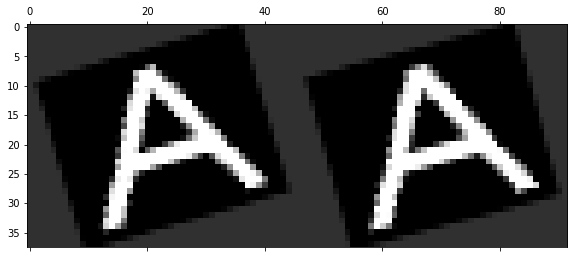

In [45]:
plt.matshow(np.hstack((tformed[opt_i][opt_j], arr_A_affine_simple)))

#### "Hacky" affine optimisation method (bad, do not use)

In [853]:
def affine_optimisation_hacky(arr_moving: np.array, arr_ref: np.array, grid_dim=5, num_samples=15, num_iterations=20, scale_x_min=0.5, scale_x_max=2, scale_y_min=0.5, scale_y_max=2, shear_radians_min=-math.pi/3, shear_radians_max=math.pi/3, rotate_radians_min=-math.pi, rotate_radians_max=math.pi, offset_x_min=-10, offset_x_max=10, offset_y_min=-10, offset_y_max=10):
    num_samples_original = num_samples    
    scale_x_min_original = scale_x_min
    scale_x_max_original = scale_x_max
    scale_y_min_original = scale_y_min
    scale_y_max_original = scale_y_max
    shear_radians_min_original = shear_radians_min
    shear_radians_max_original = shear_radians_max
    rotate_radians_min_original = rotate_radians_min
    rotate_radians_max_original = rotate_radians_max
    offset_x_min_original = offset_x_min
    offset_x_max_original = offset_x_max
    offset_y_min_original = offset_y_min
    offset_y_max_original = offset_y_max
        
    def affine_optimisation_hacky_internal(arr_moving: np.array, arr_ref: np.array, scale_x_min, scale_x_max, scale_y_min, scale_y_max, shear_radians_min, shear_radians_max, rotate_radians_min, rotate_radians_max, offset_x_min, offset_x_max, offset_y_min, offset_y_max):
        assert scale_x_max >= scale_x_min
        assert scale_y_max >= scale_y_min
        assert shear_radians_max >= shear_radians_min
        assert rotate_radians_max >= rotate_radians_min
        assert offset_x_max >= offset_x_min
        assert offset_y_max >= offset_y_min
        step_scale_x = (scale_x_max - scale_x_min)/(grid_dim-1)
        step_scale_y = (scale_y_max - scale_y_min)/(grid_dim-1)
        step_shear = (shear_radians_max - shear_radians_min)/(grid_dim-1)
        step_rotation = (rotate_radians_max - rotate_radians_min)/(grid_dim-1)
        step_offset_x = (offset_x_max - offset_x_min)/(grid_dim-1)
        step_offset_y = (offset_y_max - offset_y_min)/(grid_dim-1)
        max_sample_index = grid_dim**6 - 1
        sample_indices = (np.array(range(num_samples)) * max_sample_index / (num_samples - 1)) // 1
        def num_to_base(num, base, max_index):
            # Tested on paper, seems to work as intended
            digits = []
            remainder = num
            for i in range(max_index):
                # current_index is initially max_index-1 and ends up at zero
                current_index = max_index - i - 1
                digits.append(remainder // (base**current_index))
                remainder = remainder % (base**current_index)
            return digits
        def digits_to_values(digits):
            assert len(digits) == 6
            values = [scale_x_min + step_scale_x * digits[0], scale_y_min + step_scale_y * digits[1], shear_radians_min + step_shear * digits[2], rotate_radians_min + step_rotation * digits[3], offset_x_min + step_offset_x * digits[4], offset_y_min + step_offset_y * digits[5]]
            return values
        #max_mi = 0
        #max_mi_parameter_values = np.zeros(6)
        max_mi_parameter_values = np.array([scale_x_min + scale_x_max, scale_y_min + scale_y_max, shear_radians_min + shear_radians_max, rotate_radians_min + rotate_radians_max, offset_x_min + offset_x_max, offset_y_min + offset_y_max]) * 0.5
        max_mi = ipm.mutual_information(transform_using_values(arr_moving, max_mi_parameter_values), arr_ref)
        for current_index in sample_indices:
            values = digits_to_values(num_to_base(current_index, grid_dim, 6))
            tformed = transform_using_values(arr_moving, values)
            current_mi = ipm.mutual_information(tformed, arr_ref)
            if (current_mi > max_mi):
                max_mi = current_mi
                max_mi_parameter_values = np.array(values)
        return max_mi_parameter_values
    
    def optimisation_1d_internal(parameter_index, scale_x, scale_y, shear_radians, rotate_radians, offset_x, offset_y):
        sx1 = scale_x
        sx2 = scale_x
        sy1 = scale_y
        sy2 = scale_y
        sr1 = shear_radians
        sr2 = shear_radians
        rr1 = rotate_radians
        rr2 = rotate_radians
        ox1 = offset_x
        ox2 = offset_x
        oy1 = offset_y
        oy2 = offset_y
        if parameter_index == 0:
            step_scale_x = (scale_x_max - scale_x_min)/(grid_dim-1)
            sx1 = scale_x_min
            sx2 = scale_x_max
        if parameter_index == 1:
            step_scale_y = (scale_y_max - scale_y_min)/(grid_dim-1)
            sy1 = scale_y_min
            sy2 = scale_y_max
        if parameter_index == 2:
            step_shear = (shear_radians_max - shear_radians_min)/(grid_dim-1)
            sr1 = shear_radians_min
            sr2 = shear_radians_max
        if parameter_index == 3:
            step_rotation = (rotate_radians_max - rotate_radians_min)/(grid_dim-1)
            rr1 = rotate_radians_min
            rr2 = rotate_radians_max
        if parameter_index == 4:
            step_offset_x = (offset_x_max - offset_x_min)/(grid_dim-1)
            ox1 = offset_x_min
            ox2 = offset_x_max
        if parameter_index == 5:
            step_offset_y = (offset_y_max - offset_y_min)/(grid_dim-1)
            oy1 = offset_y_min
            oy2 = offset_y_max
        max_mi_parameter_values = affine_optimisation_hacky_internal(arr_moving, arr_ref, sx1, sx2, sy1, sy2, sr1, sr2, rr1, rr2, ox1, ox2, oy1, oy2)
        return max_mi_parameter_values
    
    #values_best = np.array([scale_x_min + scale_x_max, scale_y_min + scale_y_max, shear_radians_min + shear_radians_max, rotate_radians_min + rotate_radians_max, offset_x_min + offset_x_max, offset_y_min + offset_y_max]) * 0.5
    values_best = np.array([1, 1, 0, 0, 0, 0])
    mi_best = ipm.mutual_information(arr_ref, transform_using_values(arr_moving, values_best))
    #mi_best = ipm.mutual_information(arr_ref, arr_moving)
    index_best = -2
    n = 0
    while n < num_iterations:
        index_best = -2
            
        values_base = values_best
                
        values_6d = affine_optimisation_hacky_internal(arr_moving, arr_ref, scale_x_min, scale_x_max, scale_y_min, scale_y_max, shear_radians_min, shear_radians_max, rotate_radians_min, rotate_radians_max, offset_x_min, offset_x_max, offset_y_min, offset_y_max)
        mi_6d = 0
        try:
            mi_6d = ipm.mutual_information(arr_ref, transform_using_values(arr_moving, values_6d))
        except:
            print(str(values_6d))
        if mi_6d > mi_best:
            mi_best = mi_6d
            index_best = -1
            values_best = values_6d
            num_samples = num_samples_original
        
        for i in range(6):
            values_current = optimisation_1d_internal(i, values_base[0], values_base[1], values_base[2], values_base[3], values_base[4], values_base[5])
            mi_current = ipm.mutual_information(arr_ref, transform_using_values(arr_moving, values_current))
            if mi_current > mi_best:
                index_best = i
                values_best = values_current
                mi_best = mi_current
                num_samples = num_samples_original
                
        step_scale_x = (scale_x_max - scale_x_min)/(grid_dim-1)
        step_scale_y = (scale_y_max - scale_y_min)/(grid_dim-1)
        step_shear = (shear_radians_max - shear_radians_min)/(grid_dim-1)
        step_rotation = (rotate_radians_max - rotate_radians_min)/(grid_dim-1)
        step_offset_x = (offset_x_max - offset_x_min)/(grid_dim-1)
        step_offset_y = (offset_y_max - offset_y_min)/(grid_dim-1)
        if index_best == -2:
            num_samples += int(num_samples_original * 0.1)
            if num_samples > num_samples_original*2:
                break
        if index_best == -1:
            scale_x_min = max(scale_x_min_original, min(scale_x_min + step_scale_x, values_best[0] - step_scale_x))
            scale_x_max = min(scale_x_max_original, max(scale_x_max - step_scale_x, values_best[0] + step_scale_x))
            scale_y_min = max(scale_y_min_original, min(scale_y_min + step_scale_y, values_best[1] - step_scale_y))
            scale_y_max = min(scale_y_max_original, max(scale_y_max - step_scale_y, values_best[1] + step_scale_y))
            shear_radians_min = max(shear_radians_min_original, min(shear_radians_min + step_shear, values_best[2] - step_shear))
            shear_radians_max = min(shear_radians_max_original, max(shear_radians_max - step_shear, values_best[2] + step_shear))
            rotate_radians_min = max(rotate_radians_min_original, min(rotate_radians_min + step_rotation, values_best[3] - step_rotation))
            rotate_radians_max = min(rotate_radians_max_original, max(rotate_radians_max - step_rotation, values_best[3] + step_rotation))
            offset_x_min = max(offset_x_min_original, min(offset_x_min + step_offset_x, values_best[4] - step_offset_x))
            offset_x_max = min(offset_x_max_original, max(offset_x_max - step_offset_x, values_best[4] + step_offset_x))
            offset_y_min = max(offset_y_min_original, min(offset_y_min + step_offset_y, values_best[5] - step_offset_y))
            offset_y_max = min(offset_y_max_original, max(offset_y_max - step_offset_y, values_best[5] + step_offset_y))
        if index_best == 0:
            #scale_x_min = max(scale_x_min_original, values_best[0] - step_scale_x)
            #scale_x_max = min(scale_x_max_original, values_best[0] + step_scale_x)
            scale_x_min = max(scale_x_min_original, min(scale_x_min + step_scale_x, values_best[0] - step_scale_x))
            scale_x_max = min(scale_x_max_original, max(scale_x_max - step_scale_x, values_best[0] + step_scale_x))
        if index_best == 1:
            #scale_y_min = max(scale_y_min_original, values_best[1] - step_scale_y)
            #scale_y_max = min(scale_y_max_original, values_best[1] + step_scale_y)
            scale_y_min = max(scale_y_min_original, min(scale_y_min + step_scale_y, values_best[1] - step_scale_y))
            scale_y_max = min(scale_y_max_original, max(scale_y_max - step_scale_y, values_best[1] + step_scale_y))
        if index_best == 2:
            #shear_radians_min = max(shear_radians_min_original, values_best[2] - step_shear)
            #shear_radians_max = min(shear_radians_max_original, values_best[2] + step_shear)
            shear_radians_min = max(shear_radians_min_original, min(shear_radians_min + step_shear, values_best[2] - step_shear))
            shear_radians_max = min(shear_radians_max_original, max(shear_radians_max - step_shear, values_best[2] + step_shear))
        if index_best == 3:
            #rotate_radians_min = max(rotate_radians_min_original, values_best[3] - step_rotation)
            #rotate_radians_max = min(rotate_radians_max_original, values_best[3] + step_rotation)
            rotate_radians_min = max(rotate_radians_min_original, min(rotate_radians_min + step_rotation, values_best[3] - step_rotation))
            rotate_radians_max = min(rotate_radians_max_original, max(rotate_radians_max - step_rotation, values_best[3] + step_rotation))
        if index_best == 4:
            #offset_x_min = max(offset_x_min_original, values_best[4] - step_offset_x)
            #offset_x_max = min(offset_x_max_original, values_best[4] + step_offset_x)
            offset_x_min = max(offset_x_min_original, min(offset_x_min + step_offset_x, values_best[4] - step_offset_x))
            offset_x_max = min(offset_x_max_original, max(offset_x_max - step_offset_x, values_best[4] + step_offset_x))
        if index_best == 5:
            #offset_y_min = max(offset_y_min_original, values_best[5] - step_offset_y)
            #offset_y_max = min(offset_y_max_original, values_best[5] + step_offset_y)
            offset_y_min = max(offset_y_min_original, min(offset_y_min + step_offset_y, values_best[5] - step_offset_y))
            offset_y_max = min(offset_y_max_original, max(offset_y_max - step_offset_y, values_best[5] + step_offset_y))
        n += 1
            
    return [n, index_best, values_best, num_samples, [scale_x_min, scale_y_min, shear_radians_min, rotate_radians_min, offset_x_min, offset_y_min], [scale_x_max, scale_y_max, shear_radians_max, rotate_radians_max, offset_x_max, offset_y_max]]

In [904]:
[n_0, index_best_0, values_hacky_0, ns_0, mins_0, maxes_0] = affine_optimisation_hacky(arr_A, arr_A_affine_v2, grid_dim=25, num_samples=90, num_iterations=0, scale_x_min=0.2, offset_x_min=-arr_A.shape[1], offset_x_max=arr_A.shape[1], offset_y_min=-arr_A.shape[0], offset_y_max=arr_A.shape[0])
[n_1, index_best_1, values_hacky_1, ns_1, mins_1, maxes_1] = affine_optimisation_hacky(arr_A, arr_A_affine_v2, grid_dim=25, num_samples=90, num_iterations=1, scale_x_min=0.2, offset_x_min=-arr_A.shape[1], offset_x_max=arr_A.shape[1], offset_y_min=-arr_A.shape[0], offset_y_max=arr_A.shape[0])
[n_2, index_best_2, values_hacky_2, ns_2, mins_2, maxes_2] = affine_optimisation_hacky(arr_A, arr_A_affine_v2, grid_dim=25, num_samples=90, num_iterations=2, scale_x_min=0.2, offset_x_min=-arr_A.shape[1], offset_x_max=arr_A.shape[1], offset_y_min=-arr_A.shape[0], offset_y_max=arr_A.shape[0])
[n_3, index_best_3, values_hacky_3, ns_3, mins_3, maxes_3] = affine_optimisation_hacky(arr_A, arr_A_affine_v2, grid_dim=25, num_samples=90, num_iterations=3, scale_x_min=0.2, offset_x_min=-arr_A.shape[1], offset_x_max=arr_A.shape[1], offset_y_min=-arr_A.shape[0], offset_y_max=arr_A.shape[0])
[n_4, index_best_4, values_hacky_4, ns_4, mins_4, maxes_4] = affine_optimisation_hacky(arr_A, arr_A_affine_v2, grid_dim=25, num_samples=90, num_iterations=4, scale_x_min=0.2, offset_x_min=-arr_A.shape[1], offset_x_max=arr_A.shape[1], offset_y_min=-arr_A.shape[0], offset_y_max=arr_A.shape[0])
[n_5, index_best_5, values_hacky_5, ns_5, mins_5, maxes_5] = affine_optimisation_hacky(arr_A, arr_A_affine_v2, grid_dim=25, num_samples=90, num_iterations=5, scale_x_min=0.2, offset_x_min=-arr_A.shape[1], offset_x_max=arr_A.shape[1], offset_y_min=-arr_A.shape[0], offset_y_max=arr_A.shape[0])
[n_X, index_best_X, values_hacky_X, ns_X, mins_X, maxes_X] = affine_optimisation_hacky(arr_A, arr_A_affine_v2, grid_dim=25, num_samples=90, num_iterations=10, scale_x_min=0.2, offset_x_min=-arr_A.shape[1], offset_x_max=arr_A.shape[1], offset_y_min=-arr_A.shape[0], offset_y_max=arr_A.shape[0])
[n_C, index_best_C, values_hacky_C, ns_C, mins_C, maxes_C] = affine_optimisation_hacky(arr_A, arr_A_affine_v2, grid_dim=25, num_samples=90, num_iterations=100, scale_x_min=0.2, offset_x_min=-arr_A.shape[1], offset_x_max=arr_A.shape[1], offset_y_min=-arr_A.shape[0], offset_y_max=arr_A.shape[0])
[n_M, index_best_M, values_hacky_M, ns_M, mins_M, maxes_M] = affine_optimisation_hacky(arr_A, arr_A_affine_v2, grid_dim=25, num_samples=90, num_iterations=1000, scale_x_min=0.2, offset_x_min=-arr_A.shape[1], offset_x_max=arr_A.shape[1], offset_y_min=-arr_A.shape[0], offset_y_max=arr_A.shape[0])

In [905]:
[n_0, n_1, n_2, n_3, n_4, n_5, n_X, n_C, n_M]

[0, 1, 2, 3, 4, 5, 10, 19, 19]

In [906]:
[ns_0, ns_1, ns_2, ns_3, ns_4, ns_5, ns_X, ns_C, ns_M]

[90, 90, 90, 90, 90, 90, 99, 189, 189]

In [907]:
[index_best_0, index_best_1, index_best_2, index_best_3, index_best_4, index_best_5, index_best_X, index_best_C, index_best_M]

[-2, 3, 0, 1, 0, 2, -2, -2, -2]

In [908]:
values_hacky_0

array([1, 1, 0, 0, 0, 0])

In [909]:
np.array([mins_0, maxes_0]).T

array([[  0.2       ,   2.        ],
       [  0.5       ,   2.        ],
       [ -1.04719755,   1.04719755],
       [ -3.14159265,   3.14159265],
       [-46.        ,  46.        ],
       [-38.        ,  38.        ]])

In [910]:
values_hacky_1

array([1.        , 1.        , 0.        , 2.87979327, 0.        ,
       0.        ])

In [911]:
np.array([mins_1, maxes_1]).T

array([[  0.2       ,   2.        ],
       [  0.5       ,   2.        ],
       [ -1.04719755,   1.04719755],
       [ -2.87979327,   3.14159265],
       [-46.        ,  46.        ],
       [-38.        ,  38.        ]])

In [912]:
values_hacky_2

array([0.875     , 1.        , 0.        , 2.87979327, 0.        ,
       0.        ])

In [913]:
np.array([mins_2, maxes_2]).T

array([[  0.275     ,   1.925     ],
       [  0.5       ,   2.        ],
       [ -1.04719755,   1.04719755],
       [ -2.87979327,   3.14159265],
       [-46.        ,  46.        ],
       [-38.        ,  38.        ]])

In [914]:
values_hacky_5

array([0.825     , 0.875     , 0.08726646, 2.87979327, 0.        ,
       0.        ])

In [915]:
np.array([mins_5, maxes_5]).T

array([[  0.34375   ,   1.85625   ],
       [  0.5625    ,   1.9375    ],
       [ -0.95993109,   0.95993109],
       [ -2.87979327,   3.14159265],
       [-46.        ,  46.        ],
       [-38.        ,  38.        ]])

In [916]:
values_hacky_X

array([0.75338542, 0.79166667, 0.07999426, 2.87979327, 0.        ,
       0.        ])

In [917]:
np.array([mins_X, maxes_X]).T

array([[  0.46453993,   1.73546007],
       [  0.61979167,   1.88020833],
       [ -0.87993683,   0.87993683],
       [ -2.87979327,   3.14159265],
       [-46.        ,  46.        ],
       [-38.        ,  38.        ]])

In [918]:
values_hacky_C

array([0.75338542, 0.79166667, 0.07999426, 2.87979327, 0.        ,
       0.        ])

In [919]:
np.array([mins_C, maxes_C]).T

array([[  0.46453993,   1.73546007],
       [  0.61979167,   1.88020833],
       [ -0.87993683,   0.87993683],
       [ -2.87979327,   3.14159265],
       [-46.        ,  46.        ],
       [-38.        ,  38.        ]])

In [920]:
values_hacky_M

array([0.75338542, 0.79166667, 0.07999426, 2.87979327, 0.        ,
       0.        ])

In [921]:
np.array([mins_M, maxes_M]).T

array([[  0.46453993,   1.73546007],
       [  0.61979167,   1.88020833],
       [ -0.87993683,   0.87993683],
       [ -2.87979327,   3.14159265],
       [-46.        ,  46.        ],
       [-38.        ,  38.        ]])

In [922]:
[scale_x, scale_y, shear_radians, rotate_radians, offset_x, offset_y]

[0.5, 1.1, 0.0, 0.5235987755982988, 3.0, -5.0]

In [923]:
[ipm.mutual_information(arr_A_affine_v2, transform_using_values(arr_A, values_hacky_0)), ipm.mutual_information(arr_A_affine_v2, transform_using_values(arr_A, values_hacky_1)), ipm.mutual_information(arr_A_affine_v2, transform_using_values(arr_A, values_hacky_2)), ipm.mutual_information(arr_A_affine_v2, transform_using_values(arr_A, values_hacky_3)), ipm.mutual_information(arr_A_affine_v2, transform_using_values(arr_A, values_hacky_4)), ipm.mutual_information(arr_A_affine_v2, transform_using_values(arr_A, values_hacky_5)), ipm.mutual_information(arr_A_affine_v2, transform_using_values(arr_A, values_hacky_X)), ipm.mutual_information(arr_A_affine_v2, transform_using_values(arr_A, values_hacky_C)), ipm.mutual_information(arr_A_affine_v2, transform_using_values(arr_A, values_hacky_M))]

[0.0170532684699702,
 0.0893264570222628,
 0.13145428027006795,
 0.13605081608304284,
 0.148607710105917,
 0.1581462430436594,
 0.19235743374756897,
 0.19235743374756897,
 0.19235743374756897]

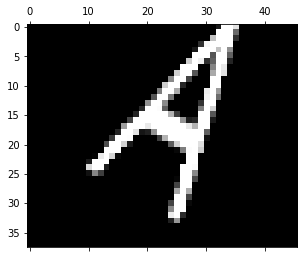

In [924]:
plt.matshow(arr_A_affine_v2)

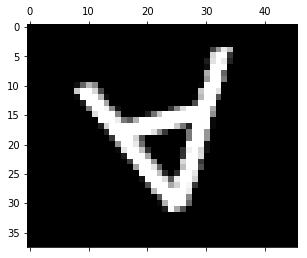

In [925]:
plt.matshow(transform_using_values(arr_A, values_hacky_C))

#### `cartesian_to_log_polar(arr_in: np.array)`

In [27]:
arr_A_log_polar = ipm.cartesian_to_log_polar(arr_A)

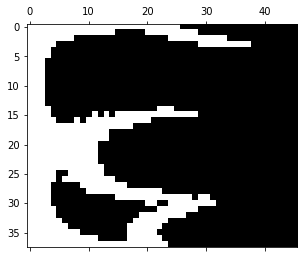

In [28]:
plt.matshow(arr_A_log_polar)

In [37]:
#arr_A_big = scipy.misc.imresize(arr_A, 4.0)
arr_A_big = skimage.transform.resize(arr_A, (arr_A.shape[0]*64.0, arr_A.shape[1]*64.0), mode='reflect', anti_aliasing=True)

In [38]:
arr_A_big_log_polar = ipm.cartesian_to_log_polar(arr_A_big)

In [39]:
plt.matshow(arr_A_big_log_polar)

In [29]:
data_1_0_log_polar = ipm.cartesian_to_log_polar(signal_1.data[0])

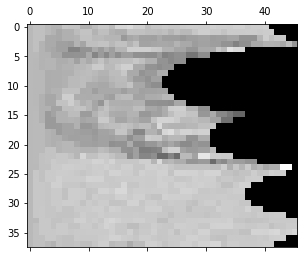

In [30]:
plt.matshow(data_1_0_log_polar)

#### `log_polar_to_cartesian(arr_in: np.array)`

In [31]:
arr_A_cartesian = ipm.log_polar_to_cartesian(arr_A_log_polar)

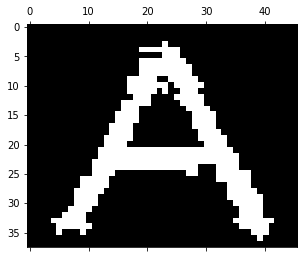

In [32]:
plt.matshow(arr_A_cartesian)

In [40]:
arr_A_big_cartesian = ipm.log_polar_to_cartesian(arr_A_big_log_polar)

In [41]:
plt.matshow(arr_A_big_cartesian)

In [42]:
arr_A_big_cartesian_downsampled = skimage.transform.resize(arr_A_big_cartesian, arr_A.shape, mode='reflect', anti_aliasing=True)

In [43]:
plt.matshow(arr_A_big_cartesian_downsampled)

In [33]:
data_1_0_cartesian = ipm.log_polar_to_cartesian(data_1_0_log_polar)

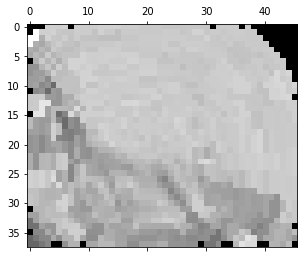

In [34]:
plt.matshow(data_1_0_cartesian)

#### Apply rigid registration to log-polar signal

In [49]:
signal_2_log_polar = ipm.log_polar_signal(signal_2)

In [50]:
shifts_2_log_polar = signal_2_log_polar.estimate_shift2D(reference='current', sobel=True, medfilter=True, hanning=True, sub_pixel_factor=50)

In [52]:
signal_2_log_polar_shifted = hs.signals.Signal2D(np.empty_like(signal_2_log_polar.data))
for t in range(signal_2_log_polar.data.shape[0]):
    vfield = np.array([np.ones_like(signal_2_log_polar.data[t]) * -shifts_2_log_polar[t][0], np.ones_like(signal_2_log_polar.data[t]) * -shifts_2_log_polar[t][1]])
    signal_2_log_polar_shifted.data[t] = ipm.apply_displacement_field_sitk(vfield, signal_2_log_polar.data[t])

In [53]:
%matplotlib qt
hs.plot.plot_signals([signal_2_log_polar, signal_2_log_polar_shifted])

In [54]:
#signal_2_cartesian = ipm.cartesian_signal(signal_2_log_polar_shifted)
signal_2_cartesian = hs.signals.Signal2D(np.empty_like(signal_2.data))
for t in range(signal_2.data.shape[0]):
    signal_2_cartesian.data[t] = ipm.rotate(signal_2.data[t], shifts_2_log_polar[t][0])

In [55]:
%matplotlib qt
hs.plot.plot_signals([signal_2, signal_2_cartesian])

In [9]:
shifts_2_cartesian = signal_2_cartesian.estimate_shift2D(reference='current', sobel=True, medfilter=True, hanning=True, sub_pixel_factor=50)

In [10]:
signal_2_cartesian_shifted = hs.signals.Signal2D(np.empty_like(signal_2_cartesian.data))
for t in range(signal_2_cartesian.data.shape[0]):
    vfield = np.array([np.ones_like(signal_2_cartesian.data[t]) * -shifts_2_cartesian[t][0], np.ones_like(signal_2_cartesian.data[t]) * -shifts_2_cartesian[t][1]])
    signal_2_cartesian_shifted.data[t] = ipm.apply_displacement_field_sitk(vfield, signal_2_cartesian.data[t])

In [11]:
%matplotlib qt
hs.plot.plot_signals([signal_2, signal_2_cartesian_shifted])